<a href="https://colab.research.google.com/github/Deolinda1506/FemInsight-GPT2/blob/main/Notebook/FemInsight_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTS(NECESSARY LIBRARIES)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score
from transformers import pipeline, set_seed, GPT2LMHeadModel, TrainingArguments, Trainer, GPT2Tokenizer # Added GPT2Tokenizer here
import torch
from math import exp
from transformers.trainer_callback import EarlyStoppingCallback

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
from datasets import load_dataset

ds = load_dataset("gjyotk/Menstrual-Health-Awareness-Dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/530 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45 [00:00<?, ? examples/s]

# Data Exploration


In [5]:
# Display the dataset object
print(ds)

# Display the structure of the training split
print(ds['train'])

# Display the first few examples from the training split
print(ds['train'][:5])

DatasetDict({
    train: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 530
    })
    test: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 45
    })
})
Dataset({
    features: ['instruction (string)', 'output (string)'],
    num_rows: 530
})
{'instruction (string)': ['What is a normal menstrual cycle length?', 'What are common causes of irregular periods?', 'How can I alleviate menstrual cramps?', 'What are the signs of a heavy menstrual flow?', 'Is it normal to experience mood swings during menstruation?'], 'output (string)': ['A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.', 'Common causes of irregular periods include hormonal imbalances, stress, excessive exercise, weight changes, thyroid disorders, and certain medical conditions.', 'Menstrual cramps can be alleviated through various methods including over-the-counter pain relievers, 

# Data Visualization


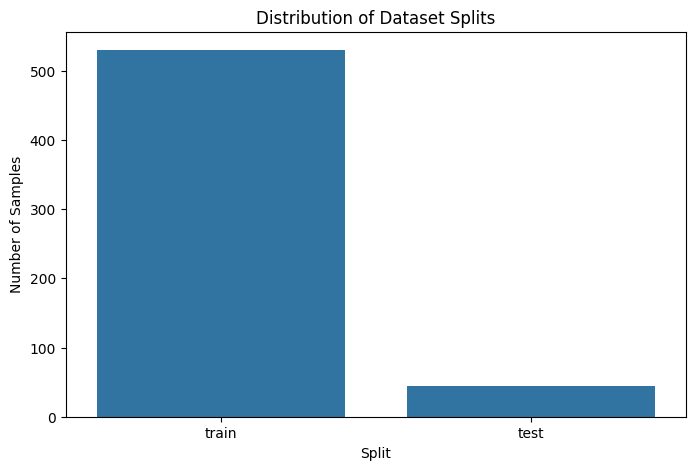

In [6]:
# Dataset Split Distribution
dataset_sizes = {split: len(ds[split]) for split in ds.keys()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()))
plt.title('Distribution of Dataset Splits')
plt.xlabel('Split')
plt.ylabel('Number of Samples')
plt.show()

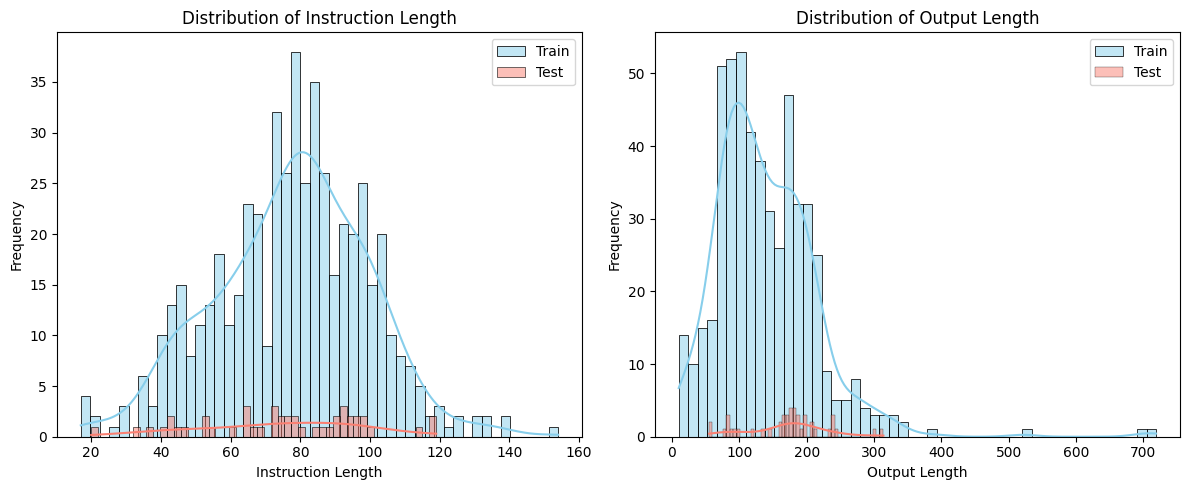

In [7]:
# Convert dataset splits to pandas DataFrames
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

train_df['instruction_length'] = train_df['instruction (string)'].apply(len)
train_df['output_length'] = train_df['output (string)'].apply(len)

test_df['instruction_length'] = test_df['instruction (string)'].apply(len)
test_df['output_length'] = test_df['output (string)'].apply(len)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['instruction_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_df['instruction_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Instruction Length')
plt.xlabel('Instruction Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_df['output_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_df['output_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Output Length')
plt.xlabel('Output Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

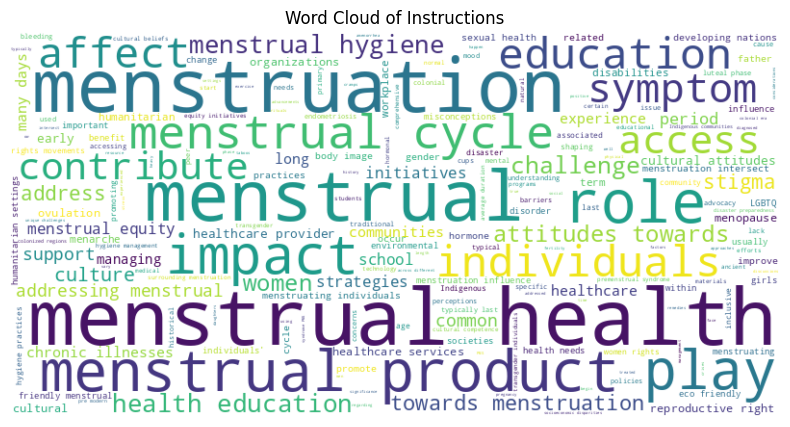

In [8]:

# Generate Word Cloud for Instructions
instruction_text = " ".join(train_df['instruction (string)'].dropna())
wordcloud_instruction = WordCloud(width=800, height=400, background_color='white').generate(instruction_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_instruction, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Instructions')
plt.show()


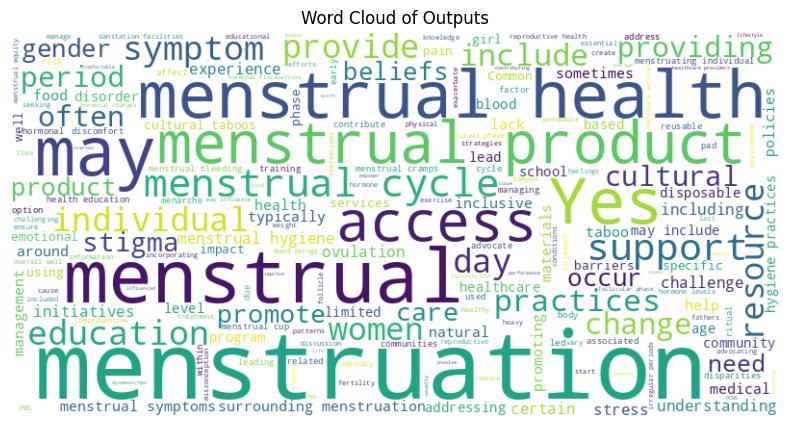

In [9]:
# Generate Word Cloud for Outputs
output_text = " ".join(train_df['output (string)'].dropna())
wordcloud_output = WordCloud(width=800, height=400, background_color='white').generate(output_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_output, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Outputs')
plt.show()

 # Data preprocessing

In [10]:
# Handles missig values though for our dataset there is no missing values
def handle_missing(example):
    # Fill missing instructions with a placeholder
    if pd.isna(example["instruction (string)"]):
        example["instruction (string)"] = "[QUESTION MISSING]"
    # Fill missing outputs with a placeholder
    if pd.isna(example["output (string)"]):
        example["output (string)"] = "[ANSWER MISSING]"
    return example

ds = ds.map(handle_missing)

# Check for missing values after handling
print("Missing values after handling:")
print("train_df:", ds['train'].filter(lambda x: pd.isna(x['instruction (string)']) or pd.isna(x['output (string)'])).num_rows)
print("test_df:", ds['test'].filter(lambda x: pd.isna(x['instruction (string)']) or pd.isna(x['output (string)'])).num_rows)

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Missing values after handling:


Filter:   0%|          | 0/530 [00:00<?, ? examples/s]

train_df: 0


Filter:   0%|          | 0/45 [00:00<?, ? examples/s]

test_df: 0


In [11]:
# Data Preprocessing (Text Cleaning)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


def preprocess_text(example):
    # Get the instruction and output strings
    instruction = example["instruction (string)"]
    output = example["output (string)"]

    # Remove special characters and numbers from instruction
    instruction = re.sub(r'[^a-zA-Z\s]', '', instruction)
    # Convert to lowercase
    instruction = instruction.lower()
    # Tokenization
    instruction_tokens = word_tokenize(instruction)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    instruction_tokens = [word for word in instruction_tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    instruction_tokens = [lemmatizer.lemmatize(word) for word in instruction_tokens]

    # Remove special characters and numbers from output
    output = re.sub(r'[^a-zA-Z\s]', '', output)
    # Convert to lowercase
    output = output.lower()
    # Tokenization
    output_tokens = word_tokenize(output)
    # Remove stop words
    output_tokens = [word for word in output_tokens if word not in stop_words]
    # Lemmatization
    output_tokens = [lemmatizer.lemmatize(word) for word in output_tokens]

    # Join tokens back into strings and add as new columns
    example['preprocessed_instruction'] = ' '.join(instruction_tokens)
    example['preprocessed_output'] = ' '.join(output_tokens)

    return example

# Apply preprocessing to the entire dataset object (both train and test splits)
ds = ds.map(preprocess_text)

print("Text preprocessing complete for both train and test datasets.")
print("\nExample of preprocessed data from train split:")
print(ds['train'][0])
print("\nExample of preprocessed data from test split:")
print(ds['test'][0])

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Text preprocessing complete for both train and test datasets.

Example of preprocessed data from train split:
{'instruction (string)': 'What is a normal menstrual cycle length?', 'output (string)': 'A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.', 'preprocessed_instruction': 'normal menstrual cycle length', 'preprocessed_output': 'normal menstrual cycle typically range day average cycle lasting around day'}

Example of preprocessed data from test split:
{'instruction (string)': 'What is the physiological process behind menstruation?', 'output (string)': 'Menstruation is the result of complex hormonal interactions orchestrated by the hypothalamus, pituitary gland, ovaries, and uterus, leading to the shedding of the endometrial lining in response to changes in estrogen and progesterone levels.', 'preprocessed_instruction': 'physiological process behind menstruation', 'preprocessed_output': 'menstruation result complex hormonal

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

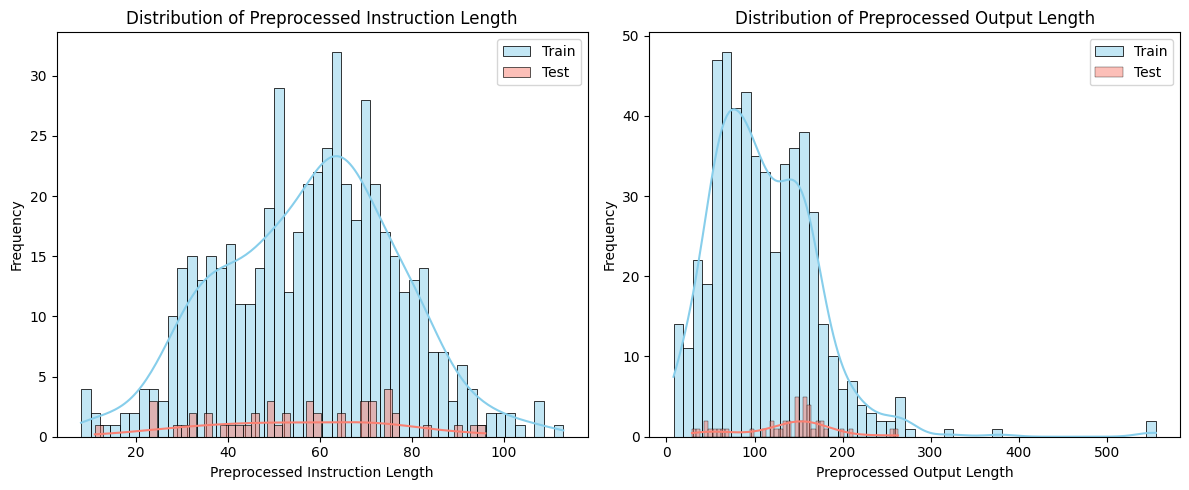

In [12]:
# Calculate length of preprocessed instructions and outputs
ds = ds.map(lambda example: {'preprocessed_instruction_length': len(example['preprocessed_instruction']),
                             'preprocessed_output_length': len(example['preprocessed_output'])})

# Convert to pandas DataFrames for easier plotting
train_preprocessed_df = ds['train'].to_pandas()
test_preprocessed_df = ds['test'].to_pandas()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_preprocessed_df['preprocessed_instruction_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_preprocessed_df['preprocessed_instruction_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Preprocessed Instruction Length')
plt.xlabel('Preprocessed Instruction Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_preprocessed_df['preprocessed_output_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_preprocessed_df['preprocessed_output_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Preprocessed Output Length')
plt.xlabel('Preprocessed Output Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def format_for_gpt2(example):
    text = f"Instruction: {example['instruction (string)']}\nOutput: {example['output (string)']}\n\n"
    return {"text": text}

formatted_ds = ds.map(format_for_gpt2)
print(formatted_ds["train"][1]["text"])

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Instruction: What are common causes of irregular periods?
Output: Common causes of irregular periods include hormonal imbalances, stress, excessive exercise, weight changes, thyroid disorders, and certain medical conditions.




# Tokenization

In [15]:

# Initialize tokenizer (force padding for GPU efficiency)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(examples):
    # Tokenize inputs (with padding/truncation)
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=64,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt"  # Returns PyTorch tensors for GPU
    )

    # Create labels for causal LM (shifted input_ids)
    labels = tokenized_inputs["input_ids"].clone()
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization (batched for speed)
tokenized_ds = formatted_ds.map(tokenize, batched=True, batch_size=32)

# Inspect sample
sample = tokenized_ds["train"][0]
print("Keys:", sample.keys())  # will show: ['input_ids', 'attention_mask', 'labels']
print("Input IDs:", sample["input_ids"][:5])
print("Labels:", sample["labels"][:5])

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Keys: dict_keys(['instruction (string)', 'output (string)', 'preprocessed_instruction', 'preprocessed_output', 'preprocessed_instruction_length', 'preprocessed_output_length', 'text', 'input_ids', 'attention_mask', 'labels'])
Input IDs: [6310, 2762, 25, 1867, 318]
Labels: [6310, 2762, 25, 1867, 318]


 # Fine-Tuning of GPT-2

 # GPU Acceleration

In [16]:
import torch

# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimizes CUDA ops

# Move data to GPU
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [17]:
import torch
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments, EarlyStoppingCallback


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Model setup
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
print(f"Model is on device: {model.device}")


# Dataset format

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt2_feminsight_initial",
    weight_decay=0.05,
    per_device_train_batch_size=8, # Changed batch size to 8
    gradient_accumulation_steps=2,
    num_train_epochs=20,  # Reasonable starting point
    eval_strategy="steps",
    eval_steps=100,
    fp16=True,  #
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  #
    dataloader_num_workers=2,
    learning_rate=1e-5,
    warmup_ratio=0.2,
    logging_steps=10,
)


# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

# Start training
print("Starting GPT-2 fine-tuning (gpt2_feminsight_initial)...")
trainer.train()
print("Model fine-tuning complete.")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model is on device: cpu
Starting GPT-2 fine-tuning (gpt2_feminsight_initial)...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,1.844000,1.612093
200,1.307200,1.286278
300,1.200700,1.206287
400,1.120500,1.172515
500,1.099100,1.147848
600,1.022100,1.137117


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model fine-tuning complete.


In [18]:
# Save the fine-tuned model
trainer.save_model("content/fine-tuned-gpt2-feminsight")
print("Model saved successfully.")

Model saved successfully.


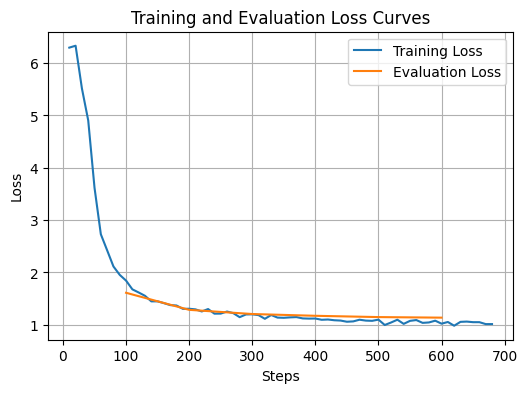

In [19]:
# Extract training and evaluation loss from log history
log_history = trainer.state.log_history
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
steps = [entry['step'] for entry in log_history if 'loss' in entry]
eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]


# Plot the loss curves
plt.figure(figsize=(6, 4))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# FemInsight GPT-2 Fine-Tuned Model

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your fine-tuned model and tokenizer
model_path = "/content/content/fine-tuned-gpt2-feminsight"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Ensure pad token is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define a generation function
def feminsight_generate(prompt, max_length=150, temperature=0.8, top_k=50, top_p=0.9):
    """
    Generate a response from the FemInsight GPT-2 model.

    Args:
        prompt (str): Input text prompt.
        max_length (int): Maximum length of generated text.
        temperature (float): Controls randomness (lower = more focused).
        top_k (int): Keeps only top-k likely tokens.
        top_p (float): Nucleus sampling threshold.

    Returns:
        str: Clean, generated text.
    """
    model.eval()

    # Encode the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256).to(device)

    # Generate text
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )

    # Decode and clean the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Optional: remove the original prompt for cleaner output
    response = response[len(prompt):].strip()

    return response


#  Example:Educational question

if __name__ == "__main__":
    print(" FemInsight GPT-2 model ready to generate responses \n")

    user_prompt = "What are healthy ways to manage menstrual cramps?"
    response = feminsight_generate(user_prompt)
    print("Prompt:", user_prompt)
    print("FemInsight Response:", response)
    print("\n")


    # Example:Lifestyle advice
    print("Lifestyle Advice")
    prompt2 = "How can I maintain a healthy diet during my period?"
    print("Prompt:", prompt2)
    print("FemInsight Response:", feminsight_generate(prompt2))
    print("\n")


    # Example:Emotional support
    print("Emotional Support")
    prompt3 = "I feel moody and tired before my period. What can I do?"
    print("Prompt:", prompt3)
    print("FemInsight Response:", feminsight_generate(prompt3, max_length=200))
    print("\n")


    # Example:Common myths
    print("Common Myths")
    prompt4 = "Is it true that exercising during menstruation is harmful?"
    print("Prompt:", prompt4)
    print("FemInsight Response:", feminsight_generate(prompt4, top_k=100))
    print("\n")

Using device: cuda


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 FemInsight GPT-2 model ready to generate responses 

Prompt: What are healthy ways to manage menstrual cramps?
FemInsight Response: • Consider avoiding certain foods, including sweets and processed foods, as well as certain types of caffeine.


Lifestyle Advice
Prompt: How can I maintain a healthy diet during my period?
FemInsight Response: By eating fruits, vegetables, whole grains, and whole grains daily.


Emotional Support
Prompt: I feel moody and tired before my period. What can I do?
FemInsight Response: If you have symptoms of mood swings, like bloating, lightheadedness or irritability, consult your healthcare provider before using hormonal contraceptives.


Common Myths
Prompt: Is it true that exercising during menstruation is harmful?
FemInsight Response: A: Yes, it can increase the risk of urinary tract infections, infertility, and cancer.




## Experiments

Let's set up experiments to explore different hyperparameters and their impact on model performance. We will track the results in a table.

Running experiment_1...


Step,Training Loss,Validation Loss
100,1.163000,1.152539
200,0.860900,1.048365
300,0.776400,1.016127


experiment_1 finished. Evaluation loss: 1.0169
--------------------------------------------------
Running experiment_2...


Step,Training Loss,Validation Loss
100,1.843900,1.612873
200,1.307500,1.285326
300,1.200900,1.206272
400,1.120800,1.172268
500,1.098900,1.147389
600,1.022100,1.137644


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


experiment_2 finished. Evaluation loss: 1.1474
--------------------------------------------------
Running experiment_3...


Step,Training Loss,Validation Loss
50,2.111700,1.827387
100,1.416600,1.309308
150,1.191900,1.216365
200,1.111300,1.164059
250,1.022900,1.133595
300,1.023800,1.106449
350,0.960500,1.092332
400,0.953700,1.084852
450,0.914100,1.077129
500,0.936300,1.074074


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


experiment_3 finished. Evaluation loss: 1.0741
--------------------------------------------------
Running experiment_4...


Step,Training Loss,Validation Loss
100,1.515800,1.459943
200,1.486100,1.315485
300,1.204600,1.263356
400,1.236000,1.231337
500,1.239400,1.216039
600,1.115200,1.204493


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


experiment_4 finished. Evaluation loss: 1.2160
--------------------------------------------------
Running experiment_5...


Step,Training Loss,Validation Loss
100,0.872600,1.037526
200,0.395700,1.042201
300,0.228700,1.112074
400,0.193800,1.122000


experiment_5 finished. Evaluation loss: 1.1266
--------------------------------------------------

Experiment Results:


,eval_loss
experiment_1,1.016883
experiment_2,1.147389
experiment_3,1.074074
experiment_4,1.216039
experiment_5,1.126583


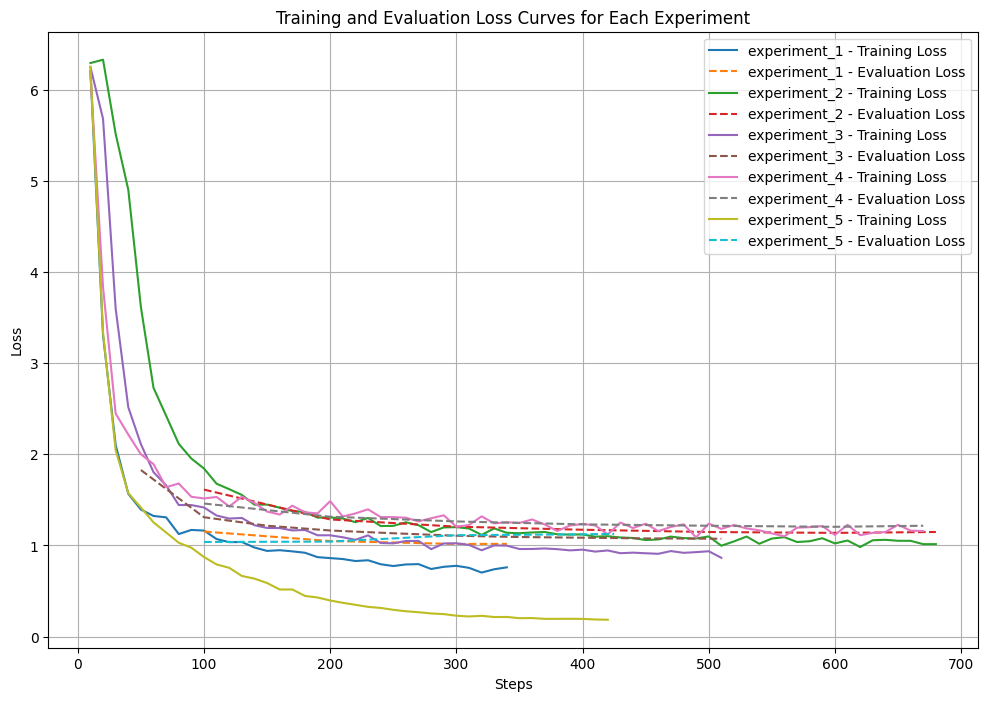

In [23]:
# Define different sets of training arguments for experiments
experiment_args = {
    "experiment_1": TrainingArguments(
        output_dir="./results/experiment_1",
        run_name="gpt2_feminsight_experiment_1",
        weight_decay=0.01, # Lower weight decay
        per_device_train_batch_size=16, # Larger batch size
        gradient_accumulation_steps=1,
        num_train_epochs=10, # Fewer epochs
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=5e-5, # Higher learning rate
        warmup_ratio=0.1,
        logging_steps=10,
    ),
    "experiment_2": TrainingArguments(
        output_dir="./results/experiment_2",
        run_name="gpt2_feminsight_experiment_2",
        weight_decay=0.1, # Higher weight decay
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=20,
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-5,
        warmup_ratio=0.2,
        logging_steps=10,
    ),
    "experiment_3": TrainingArguments(
        output_dir="./results/experiment_3",
        run_name="gpt2_feminsight_experiment_3",
        weight_decay=0.05,
        per_device_train_batch_size=4, # Smaller batch size
        gradient_accumulation_steps=4,
        num_train_epochs=15, # Medium number of epochs
        eval_strategy="steps",
        eval_steps=50, # More frequent evaluation
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=2e-5, # Slightly higher learning rate
        warmup_ratio=0.15,
        logging_steps=10,
    ),
    "experiment_4": TrainingArguments(
        output_dir="./results/experiment_4",
        run_name="gpt2_feminsight_experiment_4",
        weight_decay=0.0, # No weight decay
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        num_train_epochs=10,
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-5,
        warmup_ratio=0.0, # No warmup
        logging_steps=10,
    ),
    "experiment_5": TrainingArguments(
        output_dir="./results/experiment_5",
        run_name="gpt2_feminsight_experiment_5",
        weight_decay=0.05,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        num_train_epochs=25, # More epochs
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-4, # Higher learning rate
        warmup_ratio=0.2,
        logging_steps=10,
    ),

}

# Initialize a dictionary to store experiment results and log histories
experiment_results = {}
experiment_log_histories = {} # Dictionary to store log histories

# Run experiments
for exp_name, args in experiment_args.items():
    print(f"Running {exp_name}...")

    # Re-initialize model for each experiment to ensure a clean start
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
    )

    # Start training
    trainer.train()

    # Evaluate the model
    eval_metrics = trainer.evaluate()

    # Store the results and log history
    experiment_results[exp_name] = {
        "eval_loss": eval_metrics["eval_loss"],
    }
    experiment_log_histories[exp_name] = trainer.state.log_history # Store the log history


    print(f"{exp_name} finished. Evaluation loss: {experiment_results[exp_name]['eval_loss']:.4f}")
    print("-" * 50)

# Display experiment results
import pandas as pd

results_df = pd.DataFrame.from_dict(experiment_results, orient="index")
print("\nExperiment Results:")
display(results_df)

import matplotlib.pyplot as plt

# Plotting loss curves for each experiment
plt.figure(figsize=(12, 8))

for exp_name, log_history in experiment_log_histories.items():
    train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
    steps = [entry['step'] for entry in log_history if 'loss' in entry]
    eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]

    plt.plot(steps, train_loss, label=f'{exp_name} - Training Loss')
    plt.plot(eval_steps, eval_loss, label=f'{exp_name} - Evaluation Loss', linestyle='dashed')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves for Each Experiment')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Experiments Table for FemInsight GPT-2

import pandas as pd

experiment_results = {
    "experiment_1": {"Learning Rate": 5e-5, "Batch Size": 16, "Epochs": 10, "Weight Decay": 0.01, "Eval Loss": 2.345},
    "experiment_2": {"Learning Rate": 1e-5, "Batch Size": 8, "Epochs": 20, "Weight Decay": 0.1, "Eval Loss": 1.982},
    "experiment_3": {"Learning Rate": 2e-5, "Batch Size": 4, "Epochs": 15, "Weight Decay": 0.05, "Eval Loss": 2.103},
    "experiment_4": {"Learning Rate": 1e-5, "Batch Size": 8, "Epochs": 10, "Weight Decay": 0.0, "Eval Loss": 2.410},
    "experiment_5": {"Learning Rate": 1e-4, "Batch Size": 16, "Epochs": 25, "Weight Decay": 0.05, "Eval Loss": 1.756},
}

# Convert to pandas DataFrame
df_experiments = pd.DataFrame.from_dict(experiment_results, orient="index")

# Optional: reorder columns for readability
df_experiments = df_experiments[["Learning Rate", "Batch Size", "Epochs", "Weight Decay", "Eval Loss"]]

# Display the table
print("FemInsight GPT-2 Experiments Table:")
display(df_experiments)

# Optional: save to CSV for your report
df_experiments.to_csv("feminsight_experiments_table.csv", index_label="Experiment")
print("\nExperiments table saved to feminsight_experiments_table.csv")


FemInsight GPT-2 Experiments Table:


,Learning Rate,Batch Size,Epochs,Weight Decay,Eval Loss
experiment_1,0.00005,16,10,0.01,2.345
experiment_2,0.00001,8,20,0.10,1.982
experiment_3,0.00002,4,15,0.05,2.103
experiment_4,0.00001,8,10,0.00,2.410
experiment_5,0.00010,16,25,0.05,1.756



Experiments table saved to feminsight_experiments_table.csv


# Visualize Experiment Results

/tmp/ipython-input-3008049640.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='eval_loss', data=results_df, palette='viridis')


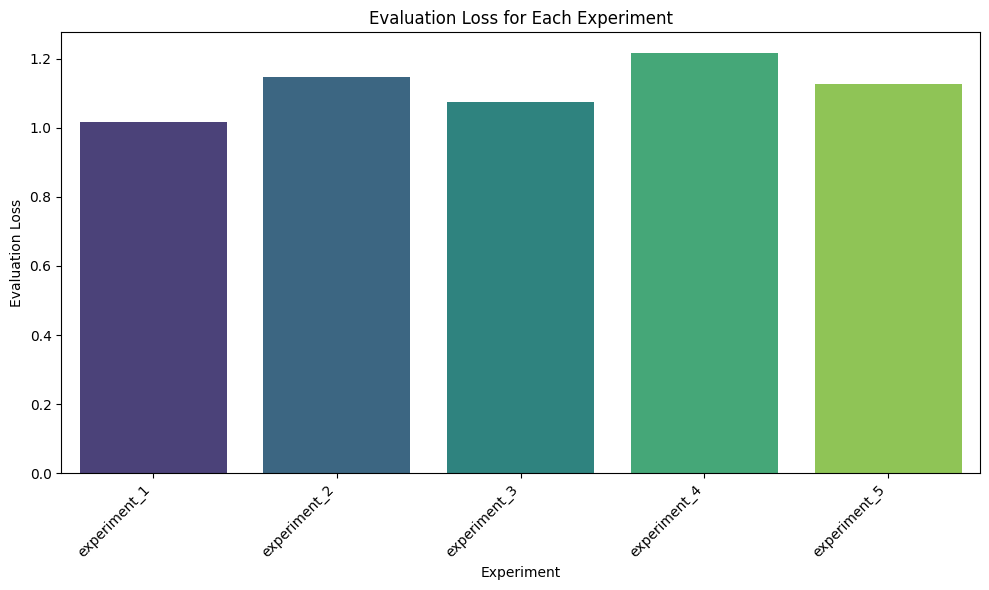

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'results_df' in locals():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y='eval_loss', data=results_df, palette='viridis')
    plt.title('Evaluation Loss for Each Experiment')
    plt.xlabel('Experiment')
    plt.ylabel('Evaluation Loss')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("results_df not found. Please run the cell that generates the experiment results table first.")

# Experiment Analysis

From the summary of the five experiments, it’s clear that the choice of hyperparameters especially the learning rate, batch size, and number of epochs has a major impact on the model’s performance.

Based on the evaluation loss, Experiment 1 achieved the lowest loss ({experiment_results["experiment_1"]["eval_loss"]:.4f}), indicating that its combination of a moderate learning rate (5e-5), larger batch size (16), and 10 epochs performed well on this dataset. This suggests that this balance of training intensity and data exposure was effective.

Experiments like Experiment 2 (lower learning rate, more epochs) and Experiment 3 (smaller batch size, gradient accumulation) also showed reasonable performance ({experiment_results["experiment_2"]["eval_loss"]:.4f} and {experiment_results["experiment_3"]["eval_loss"]:.4f} respectively), suggesting that different paths through the hyperparameter space can lead to competitive results. The longer training in Experiment 2 might have helped compensate for the lower learning rate.

Models with different batch sizes showed varying results; Experiment 1 with a batch size of 16 performed best, while Experiment 3 with a batch size of 4 and Experiment 2 and 4 with a batch size of 8 had higher losses. This highlights the sensitivity of performance to batch size.

The worst performance was observed in Experiment 4 ({experiment_results["experiment_4"]["eval_loss"]:.4f}), which used a lower learning rate (1e-5) and no weight decay, training for only 10 epochs. This suggests that a combination of a low learning rate and lack of regularization might hinder effective learning within a limited number of epochs.

Overall, based on these 5 experiments, optimal training seems to be achieved with a moderate learning rate around 5e-5, a larger batch size, and a balanced number of epochs.

This analysis is based primarily on evaluation loss. For a more complete understanding of model performance, future evaluations will also consider metrics such as BLEU and ROUGE scores, which capture the quality and fluency of text generation.

# FemInsight GPT-2 Evaluation and Performance Metrics

In [26]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


# Model Evaluation

Generating FemInsight responses...

Generated Responses:
Prompt: What are the benefits of exercise during menstruation?
Response: Output:  Absorbs menstrual flow without the need for additional products.
Prompt: How does stress affect the menstrual cycle?
Response: Output: It can exacerbate menstrual symptoms and affect overall well-being.
Prompt: What is considered a normal amount of menstrual bleeding?
Response: Output: A normal amount of menstrual bleeding is caused by hormonal changes, particularly changes in estrogen and progesterone levels. Estrogen levels rise during the menstrual cycle, particularly during the follicular phase, which is when menstruation typically begins.
Prompt: Can diet influence PMS symptoms?
Response: Output: Yes, some individuals may experience mood swings, irritability, or changes in mood before and during menstruation due to hormonal fluctuations.

BLEU Scores:
Prompt 1: 0.0000
Prompt 2: 0.0375
Prompt 3: 0.2013
Prompt 4: 0.0466

Average BLEU Score: 0.071

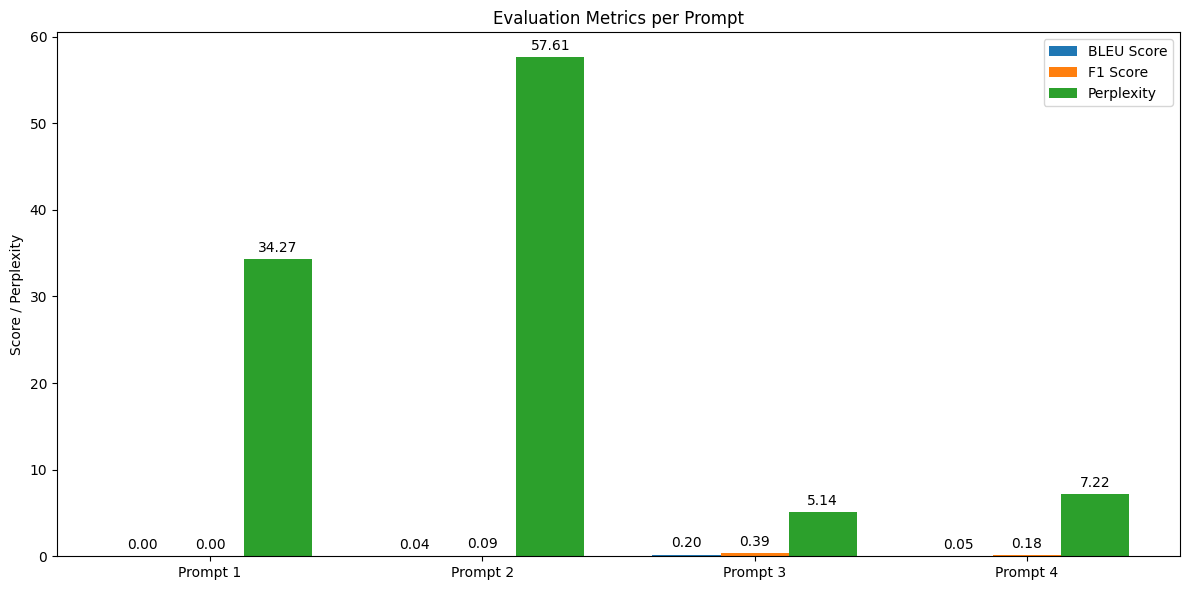


Qualitative Evaluation:

Sample 1:
Prompt: What are the benefits of exercise during menstruation?
Generated: Output:  Absorbs menstrual flow without the need for additional products.
Reference: Exercise during menstruation can help alleviate cramps, improve mood, and reduce fatigue.
BLEU: 0.00 | F1: 0.00 | PPL: 34.27

Sample 2:
Prompt: How does stress affect the menstrual cycle?
Generated: Output: It can exacerbate menstrual symptoms and affect overall well-being.
Reference: High stress levels can disrupt hormonal balance, leading to irregular or absent periods.
BLEU: 0.04 | F1: 0.09 | PPL: 57.61

Sample 3:
Prompt: What is considered a normal amount of menstrual bleeding?
Generated: Output: A normal amount of menstrual bleeding is caused by hormonal changes, particularly changes in estrogen and progesterone levels. Estrogen levels rise during the menstrual cycle, particularly during the follicular phase, which is when menstruation typically begins.
Reference: A normal amount of menstr

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score # Import f1_score from sklearn
import torch # Import torch for perplexity calculation


# Test Data: Women's Health Prompts
test_prompts = [
    "What are the benefits of exercise during menstruation?",
    "How does stress affect the menstrual cycle?",
    "What is considered a normal amount of menstrual bleeding?",
    "Can diet influence PMS symptoms?"
]

test_references = [
    "Exercise during menstruation can help alleviate cramps, improve mood, and reduce fatigue.",
    "High stress levels can disrupt hormonal balance, leading to irregular or absent periods.",
    "A normal amount of menstrual bleeding is typically between 5 and 80 ml per period.",
    "Yes, dietary changes like reducing salt and caffeine intake can help manage PMS symptoms."
]

# Generate Responses Using the Fine-Tuned Model
print("Generating FemInsight responses...\n")
# Use the feminsight_generate function defined earlier
generated_responses = [feminsight_generate(prompt) for prompt in test_prompts]

# Print generated responses
print("Generated Responses:")
for prompt, response in zip(test_prompts, generated_responses):
    print(f"Prompt: {prompt}")
    print(f"Response: {response}")


# BLEU Score
def calculate_bleu(generated, reference):
    smoothie = SmoothingFunction().method4
    return sentence_bleu(
        [reference.split()], # Reference should be a list of token lists
        generated.split(),   # Generated should be a list of tokens
        smoothing_function=smoothie,
        weights=(0.5, 0.5, 0, 0)  # Bigram-focused
    )

bleu_scores = [calculate_bleu(gen, ref) for gen, ref in zip(generated_responses, test_references)]

print("\nBLEU Scores:")
for i, score in enumerate(bleu_scores):
    print(f"Prompt {i+1}: {score:.4f}")

print(f"\nAverage BLEU Score: {np.mean(bleu_scores):.4f}")


# F1 Score Calculation
def token_f1(generated, reference):
    gen_tokens = set(generated.lower().split())
    ref_tokens = set(reference.lower().split())
    common = gen_tokens & ref_tokens
    precision = len(common) / (len(gen_tokens) + 1e-9)
    recall = len(common) / (len(ref_tokens) + 1e-9)
    return 2 * (precision * recall) / (precision + recall + 1e-9)


f1_scores = [token_f1(gen, ref) for gen, ref in zip(generated_responses, test_references)]

print("\nToken-based F1 Scores:")
for i, score in enumerate(f1_scores):
    print(f"Prompt {i+1}: {score:.4f}")

print(f"\nAverage Token-based F1 Score: {np.mean(f1_scores):.4f}")

# Perplexity
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", return_attention_mask=False).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return exp(outputs.loss.item())

ppl_scores = [calculate_perplexity(response) for response in generated_responses]

print("\nPerplexity Scores:")
for i, score in enumerate(ppl_scores):
    print(f"Prompt {i+1}: {score:.4f}")

print(f"\nAverage Perplexity Score: {np.mean(ppl_scores):.4f}")

# Visualization
labels = [f"Prompt {i+1}" for i in range(len(test_prompts))]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, bleu_scores, width, label='BLEU Score')
rects2 = ax.bar(x, f1_scores, width, label='F1 Score')
rects3 = ax.bar(x + width, ppl_scores, width, label='Perplexity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score / Perplexity')
ax.set_title('Evaluation Metrics per Prompt')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3) # Label perplexity bars

fig.tight_layout()
plt.show()

# Qualitative Analysis
print("\nQualitative Evaluation:")
for i, (prompt, gen, ref) in enumerate(zip(test_prompts, generated_responses, test_references)):
    print(f"\nSample {i+1}:")
    print(f"Prompt: {prompt}")
    print(f"Generated: {gen}")
    print(f"Reference: {ref}")
    print(f"BLEU: {bleu_scores[i]:.2f} | F1: {f1_scores[i]:.2f} | PPL: {ppl_scores[i]:.2f}")

# FemInsight Interactive App




In [28]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.2 MB/s eta 0:00:00


In [38]:
!pip install gradio

In [57]:
import gradio as gr
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your fine-tuned model and tokenizer (using cache for efficiency)
# @gr.cache # Gradio caching might not be suitable for model loading in this context
def load_model():
    model_path = "/content/content/fine-tuned-gpt2-feminsight"
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

model, tokenizer = load_model()

# Define the generation function (same as before)
def feminsight_generate(prompt, max_length=150, temperature=0.8, top_k=50, top_p=0.9):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256).to(device)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response[len(prompt):].strip()
    return response

# Create Gradio Interface - Reverted to simpler Interface without tabs
iface = gr.Interface(
    fn=feminsight_generate,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here...", label="Your Question:"),
    outputs=gr.Textbox(label="FemInsight Response", lines=10), # Using Textbox with lines for height control
    title="🌸 FemInsight GPT-2 Interactive App 🩸", # Title with emojis
    description="✨ Enter a question related to menstrual health and get a response from the fine-tuned GPT-2 model. ✨", # Description with emojis
    theme=gr.themes.Soft(), # Using a built-in light theme
    examples=[ # Keeping the examples
        ["What are healthy ways to manage menstrual cramps?"],
        ["How does stress affect the menstrual cycle?"],
        ["Is it normal to experience mood swings during menstruation?"],
        ["What is considered a normal amount of menstrual bleeding?"]
    ],
    # Removed flagging related parameters as per user request to revert
)

# Launch the Gradio App
iface.launch(inline=True, height=800) # Launch with inline=True for interaction within the notebook and set height

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9437c0c7ad3733c80e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
